# How Convolution layer works?


- 기수: 14기

- 이름: 여준호

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

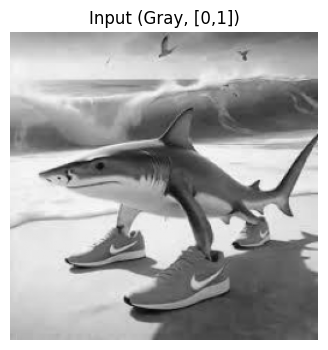

In [ ]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="./tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [ ]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    ## Todo ##
    kH, kW = kernel.shape
    H, W = image.shape
    outH = (H + 2 * padding - kH) // stride + 1
    outW = (W + 2 * padding - kW) // stride + 1
    out = np.zeros((outH, outW), dtype=np.float32)
    for i in range(outH):
        for j in range(outW):
            out[i, j] = np.sum(padded[i:i+kH, j:j+kW] * kernel)




    ##########
    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

conv2d_naive 함수는 CNN의 합성곱 연산과 동일하다. 먼저, 출력 feature map의 크기를 CNN의 공식과 동일한 방식으로 계산하고 이후 커널을 입력 위에서 슬라이딩하며 겹치는 영역을 선택한다. 여기서 해당 영역과 커널의 원소를 곱한 뒤 모두 더해 출력에 기록한다. 이는 CNN 합성곱 연산이 정의된 방식과 완전히 같은 동작으로 볼 수 있다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [ ]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [ ]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


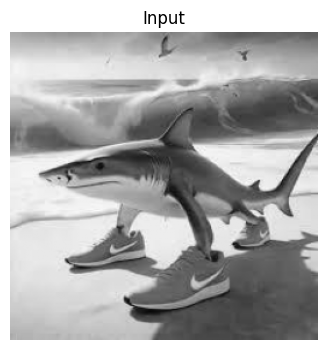

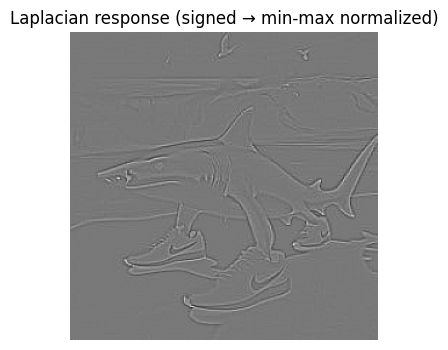

=== Sobel Vertical ===


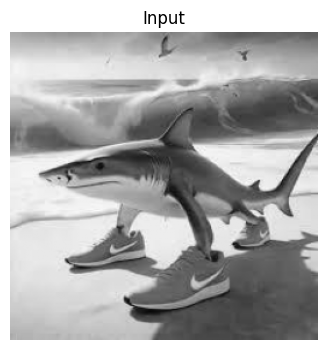

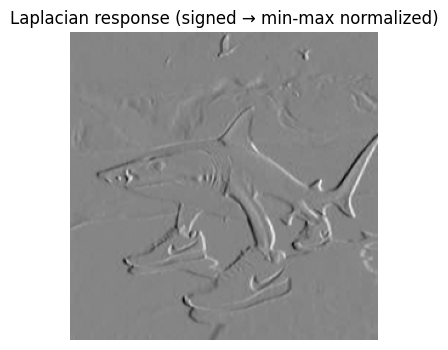

=== Sobel Horizontal ===


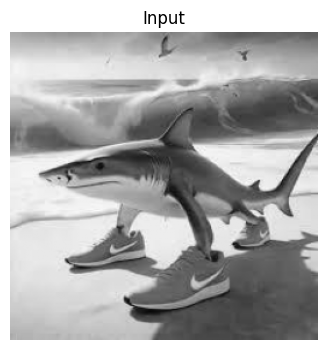

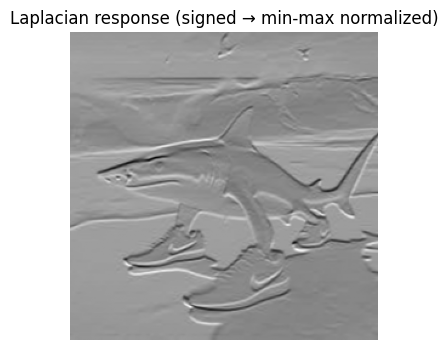

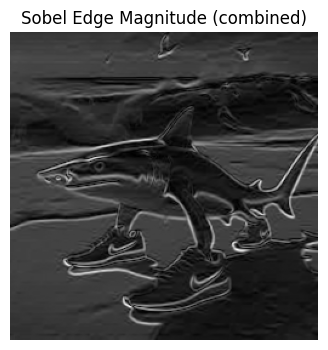

In [ ]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [ ]:
!pip install torchsummary
!pip uninstall torchvision -y
!pip install torchvision==0.23.0


Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
  Using cached torchvision-0.23.0-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
Using cached torchvision-0.23.0-cp312-cp312-win_amd64.whl (1.6 MB)


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 79.7MB/s]


In [2]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [7]:
class BasicBlock(nn.Module):

    #### Todo ####

    def __init__(self) -> None:
        super(BasicBlock, self).__init__()
        # Conv 레이어: inplanes=planes=64 기본
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.downsample = None  # 기본 None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

    ##############



class ResNet18(nn.Module):


    ###### Todo ######

    def __init__(self) -> None:
        super(ResNet18, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layer1
        self.layer1 = nn.Sequential(
            BasicBlock(),
            BasicBlock()
        )

        # layer2
        downsample2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(),  # stride 2 적용할 수 없으므로 downsample만 적용
            BasicBlock()
        )

        # layer3
        downsample3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(),
            BasicBlock()
        )

        # layer4
        downsample4 = nn.Sequential(
            nn.Conv2d(64, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(),
            BasicBlock()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)  # 마지막 feature map 채널 수는 64로 하드코딩


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    ##################

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [8]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [04:32<00:00,  1.84it/s]


Epoch 1/20, Loss: 1.380459649682045


Epoch 2/20: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]


Epoch 2/20, Loss: 0.9860986524820328


Epoch 3/20: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Epoch 3/20, Loss: 0.8125415177345275


Epoch 4/20: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


Epoch 4/20, Loss: 0.7060445915460587


Epoch 5/20: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Epoch 5/20, Loss: 0.6209911743998527


Epoch 6/20: 100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Epoch 6/20, Loss: 0.5632522228360176


Epoch 7/20: 100%|██████████| 500/500 [04:32<00:00,  1.83it/s]


Epoch 7/20, Loss: 0.5087137226462364


Epoch 8/20: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Epoch 8/20, Loss: 0.46286011251807213


Epoch 9/20: 100%|██████████| 500/500 [04:29<00:00,  1.85it/s]


Epoch 9/20, Loss: 0.4198638691306114


Epoch 10/20: 100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


Epoch 10/20, Loss: 0.3840560590326786


Epoch 11/20: 100%|██████████| 500/500 [04:17<00:00,  1.95it/s]


Epoch 11/20, Loss: 0.34796155148744584


Epoch 12/20: 100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Epoch 12/20, Loss: 0.3202464551627636


Epoch 13/20: 100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


Epoch 13/20, Loss: 0.29059423944354057


Epoch 14/20: 100%|██████████| 500/500 [04:18<00:00,  1.94it/s]


Epoch 14/20, Loss: 0.266185502499342


Epoch 15/20: 100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


Epoch 15/20, Loss: 0.24241784189641474


Epoch 16/20: 100%|██████████| 500/500 [04:22<00:00,  1.90it/s]


Epoch 16/20, Loss: 0.22171643856167794


Epoch 17/20: 100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Epoch 17/20, Loss: 0.2048692637383938


Epoch 18/20: 100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


Epoch 18/20, Loss: 0.18807429625838995


Epoch 19/20: 100%|██████████| 500/500 [04:18<00:00,  1.94it/s]


Epoch 19/20, Loss: 0.17198480205237865


Epoch 20/20: 100%|██████████| 500/500 [04:15<00:00,  1.95it/s]

Epoch 20/20, Loss: 0.16510505816340446


In [9]:
test(model, testloader, device)

Test Accuracy: 78.46%


78.46

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet18은 ImageNet(224×224) 크기, 1000개 클래스, Conv1 커널은 7×7, stride=2, maxpool 적용, BasicBlock과 layer별 채널은 64→128→256→512로 구성된다.
CIFAR10용 ResNet18은 이미지 크기 32×32, 클래스는 10개, Conv1 stride와 maxpool로 인한 정보 손실 방지 위해 stride와 커널 패딩을 조정 or maxpool 사용을 최소화한다. 또한 BasicBlock 인자를 하드코딩해서 downsample을 필요할 때만 정의하여 구현 오류를 방지했다. Layer별 채널 구성은 Original ResNet18과 동일하게 유지하면서 stride와 downsample을 최소화해 feature map 손실을 줄일 수 있다. 마지막 FC layer는 CIFAR10 클래스 수에 맞춰 512→10으로 수정한다. 이런 방식은 수정함으로써 Residual 구조와 skip connection 등 ResNet의 핵심 아이디어는 유지하면서 CIFAR10에 맞춘 학습 안정성과 성능 향상을 동시에 달성할 수 있다.
